In [1]:
# This Code will backtest a Time Series Momentum  Asset Class strategy, and highlight the utility of it when combined with traditional Beta (S&P500)

In [2]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import pyfolio as pf
import datetime as dt
from pandas.tseries.offsets import MonthEnd
import pyfolio as pf
from scipy.stats import skew
import yfinance as yfin
from itertools import chain
plt.style.use('ggplot')
pd.set_option('display.max_rows', 20) 
pd.set_option('display.max_columns', 15) 

In [3]:
# Monthly
# For self financing strategies, simply put a # in front of the first line of the sharpe() function

def mean(x,i=0):
    return print(f'Annual Return: {"{:.2f}".format(round(x.iloc[:,i][:].mean()*1200,2))}%')

def vol(x,i=0):
    return print(f'Annual Volity: {"{:.2f}".format(round(x.iloc[:,i][:].std()*(12**0.5)*100,2))}%')

def sharpe(x,i=0):
    #x = pd.DataFrame(x.iloc[:,0] - RiskFree.iloc[:,0])
    A = x.iloc[:,i][:].mean()*12
    S = x.iloc[:,i][:].std()*(12**0.5)
    return print(f'Sharpe Ratio: {"{:.2f}".format(round(A/S,2))}')

def MDD(x):
    drawdownVW = pd.DataFrame()
    drawdownVW['cumulative_returns'] = (1 + x).cumprod()
    drawdownVW['rolling_max'] = drawdownVW['cumulative_returns'].cummax()
    drawdownVW['drawdown'] = drawdownVW['cumulative_returns'] / drawdownVW['rolling_max'] - 1
    return print(f'Max Drawdown: {"{:.1f}".format(round(drawdownVW.drawdown.min()*100,1))}%')

# Organising and Cleaning

In [4]:
formation_dates = pd.date_range(start='1991-12-31',end='2022-11-30',freq='M')
returns_dates = pd.date_range(start='1992-01-31',end='2022-12-31',freq='M') 

In [5]:
data = pd.read_csv('/Users/malek/Documents/LSEG Data/LSEG Futures Data Named Title.csv',index_col=0,header=0)
data.index = pd.to_datetime(data.index,yearfirst=True)
data

,CAC 40 Future,DAX Future,DJ EURO STOXX 50,Dow Jones,FTSE 100 Future,Hang Seng Future,NASDAQ 100 E-mini,...,Interest Rate 30-Day,Long Gilt Future,Short Sterling Future,U.S. Treasury 2-Year,U.S. Treasury 5-Year,U.S. Treasury 10-Year,U.S. Treasury 30-Year
RIC,,,,,,,,,,,,,,,
1975-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1975-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1975-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1975-01-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1975-01-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-11-24,7302.0,16074.0,4383.0,35430.0,7511.5,17591.0,16021.00,...,94.6725,95.40,NaN,101.398438,105.593750,108.390625,114.84375
2023-11-27,7274.0,16017.0,4366.0,35373.0,7483.0,17562.0,16008.75,...,94.6700,96.18,NaN,101.554688,105.968750,109.000000,116.03125
2023-11-28,7257.5,16024.0,4355.0,35445.0,7476.0,17338.0,16048.00,...,94.6700,96.70,NaN,101.750000,106.429688,109.531250,116.37500


In [6]:
EQUITIES = ['CAC 40 Future','DAX Future','DJ EURO STOXX 50','Dow Jones','FTSE 100 Future','Hang Seng Future','NASDAQ 100 E-mini','Nikkei 225 Future','Russell 2000 Mini','S&P 500','S&P 500 E-mini']
BONDS = ['Euribor Future','Euro-Bobl Future','Euro-Bund Future','Euro-Schatz Future','Eurodollar','Euroswiss Future','Interest Rate 30-Day','Long Gilt Future','Short Sterling Future','U.S. Treasury 2-Year','U.S. Treasury 5-Year','U.S. Treasury 10-Year']
ENERGY = ['Brent Futures','Heating Oil Futures','Light Sweet Crude Futures','Natural Gas Futures','RBOB Gas']
METALS = ['Copper Futures','Gold Futures','Silver Futures']
AGRICULTURAL = ['Corn Futures','Cotton Futures','Lumber Futures','Soybean Futures']
GBP = ['British Pound']
CAD = ['Canadian Dollar']
EU = ['Euro']
CHF = ['Swiss Franc']

In [7]:
# For small universe
Assets = [EQUITIES,BONDS,ENERGY,METALS,AGRICULTURAL,GBP,CAD,EU,CHF]
Universe = list(chain(*Assets))
data = data[Universe]

In [8]:
returns = data.pct_change()
monthly_returns = returns.resample('M').agg(lambda x: (x+1).prod()-1)

In [9]:
past_12 = (monthly_returns+1).rolling(12).apply(np.prod)-1
past_3 = (monthly_returns+1).rolling(3).apply(np.prod)-1
past_1 = (monthly_returns+1).rolling(1).apply(np.prod)-1

In [10]:
filler = pd.DataFrame(index=formation_dates)
returns = returns.combine_first(filler)
past_std = returns.ewm(span=252,min_periods=80).std()*(252**0.5)

# Backtesting

<function matplotlib.pyplot.show(close=None, block=None)>

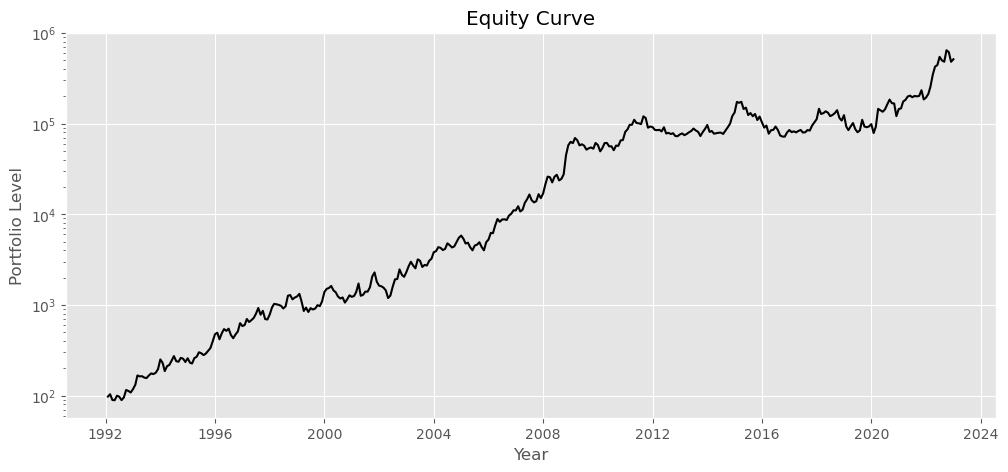

In [31]:

def Trend_Following(formation):
    end_measurement = formation
    slow_lookback = past_12.loc[formation]
    for i in Assets:
        slow_lookback[slow_lookback.index.isin(i)] = slow_lookback[slow_lookback.index.isin(i)].mean()
    slow_lookback[slow_lookback > 0]=1
    slow_lookback[slow_lookback < 0]=-1
    medium_lookback = past_3.loc[formation]
    for i in Assets:
        medium_lookback[medium_lookback.index.isin(i)] = medium_lookback[medium_lookback.index.isin(i)].mean()
    medium_lookback[medium_lookback > 0]=1
    medium_lookback[medium_lookback < 0]=-1
    fast_lookback = past_1.loc[formation]
    for i in Assets:
        fast_lookback[fast_lookback.index.isin(i)] = fast_lookback[fast_lookback.index.isin(i)].mean()
    fast_lookback[fast_lookback > 0]=1
    fast_lookback[fast_lookback < 0]=-1
    merged = pd.concat([slow_lookback,medium_lookback,fast_lookback],axis=1)
    merged['position'] = merged.sum(axis=1)
    vol_lookback = past_std.loc[end_measurement]
    vol_lookback.dropna(inplace=True)
    returns = monthly_returns.loc[end_measurement + MonthEnd(1),monthly_returns.columns.isin(merged.index)]
    wppp = pd.concat([returns,merged['position'],vol_lookback],axis=1)
    wppp = wppp[(wppp != 0).all(axis=1)]
    wppp.dropna(inplace=True)
    wppp.columns = ['1 Month Forward Returns','Signal','Ex Ante Vol Estimate']
    wppp['Inverse Volatility Weighting'] = (1/wppp['Ex Ante Vol Estimate'])/(sum(1/wppp['Ex Ante Vol Estimate']))
    wppp['IV * Signal'] = wppp['Inverse Volatility Weighting'] * wppp['Signal']
    wppp['Vol Targetted Weighting'] = wppp['IV * Signal'] * (0.30/sum(wppp['IV * Signal'].abs() * wppp['Ex Ante Vol Estimate']))
    wppp.dropna(inplace=True)
    wppp['Pounds'] = wppp['Vol Targetted Weighting'] * 500000
    Portfolio_Return = sum(wppp['1 Month Forward Returns'] * wppp['Vol Targetted Weighting'])
    return Portfolio_Return

Trend_Following_Returns = pd.DataFrame(data=[Trend_Following(i) for i in formation_dates],index=returns_dates)
equity_curve = 100*(1+Trend_Following_Returns*3.2).cumprod() 
fig = plt.figure(figsize=(12,5))
plt.plot(equity_curve.index,equity_curve,color='k')
plt.xlabel('Year')
plt.title('Equity Curve')
plt.yscale('log')
plt.ylabel('Portfolio Level')
plt.show

In [12]:
mean(Trend_Following_Returns)
vol(Trend_Following_Returns)
sharpe(Trend_Following_Returns)
MDD(Trend_Following_Returns)

Annual Return: 11.35%
Annual Volity: 13.22%
Sharpe Ratio: 0.86
Max Drawdown: -22.2%


In [13]:
skew(Trend_Following_Returns)

array([0.61781892])

<Axes: title={'center': 'Annual returns'}, xlabel='Returns', ylabel='Year'>

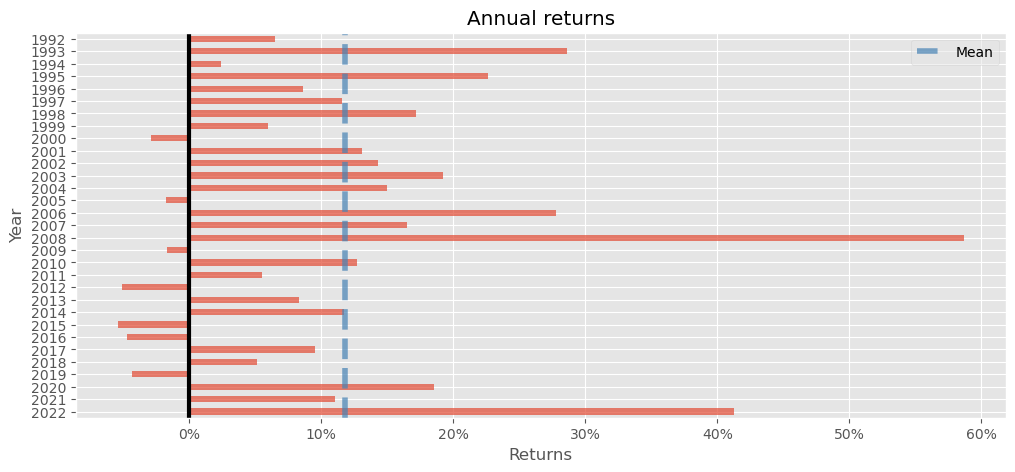

In [14]:
fig = plt.figure(figsize=(12,5))
pf.plot_annual_returns(Trend_Following_Returns)

<Axes: title={'center': 'Underwater plot'}, ylabel='Drawdown'>

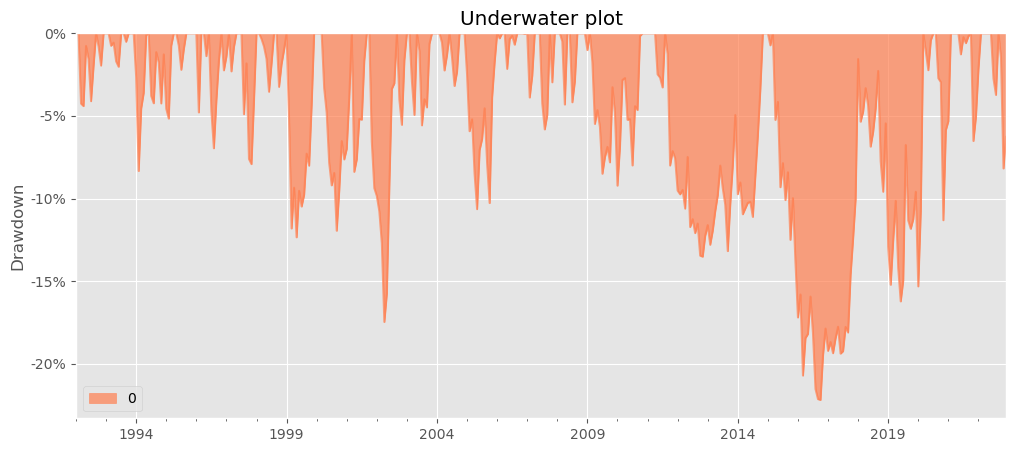

In [15]:
fig = plt.figure(figsize=(12,5))
pf.plot_drawdown_underwater(Trend_Following_Returns)

# Getting SP500 Data

In [16]:
SP500 = yfin.download('spy',start='1992-01-01',end='2022-12-31')['Close']
SP500 = SP500.pct_change()
SP500_monthly = (SP500).resample('M').agg(lambda x: (x+1).prod()-1)
SP500_monthly

[*********************100%%**********************]  1 of 1 completed


Date
1993-01-31    0.000000
1993-02-28    0.010669
1993-03-31    0.017593
1993-04-30   -0.025588
1993-05-31    0.026969
                ...   
2022-08-31   -0.040802
2022-09-30   -0.096159
2022-10-31    0.081276
2022-11-30    0.055592
2022-12-31   -0.061936
Freq: M, Name: Close, Length: 360, dtype: float64

In [17]:
Combined = pd.concat([Trend_Following_Returns[12:],SP500_monthly],axis=1)
Combined.columns = ['Trend Following','SP500']

In [18]:
Combined

,Trend Following,SP500
1993-01-31,0.036356,0.000000
1993-02-28,0.083439,0.010669
1993-03-31,-0.007549,0.017593
1993-04-30,0.001883,-0.025588
1993-05-31,-0.011350,0.026969
...,...,...
2022-08-31,-0.010147,-0.040802
2022-09-30,0.106116,-0.096159
2022-10-31,-0.015014,0.081276
2022-11-30,-0.067801,0.055592


In [19]:
# Correlation of the 2 strategies. We can see the Trend Following strategy is very defensive
Combined.corr().iloc[0,1]

-0.22539370847324372

In [20]:
# 50/50 Allocation to both
Combined['50/50'] = Combined.sum(axis=1)/2

In [21]:
Combined

,Trend Following,SP500,50/50
1993-01-31,0.036356,0.000000,0.018178
1993-02-28,0.083439,0.010669,0.047054
1993-03-31,-0.007549,0.017593,0.005022
1993-04-30,0.001883,-0.025588,-0.011852
1993-05-31,-0.011350,0.026969,0.007810
...,...,...,...
2022-08-31,-0.010147,-0.040802,-0.025474
2022-09-30,0.106116,-0.096159,0.004979
2022-10-31,-0.015014,0.081276,0.033131
2022-11-30,-0.067801,0.055592,-0.006105


In [22]:
# Combined
mean(Combined,2)
vol(Combined,2)
sharpe(Combined,2)
MDD(Combined['50/50'])

Annual Return: 9.94%
Annual Volity: 8.84%
Sharpe Ratio: 1.12
Max Drawdown: -16.3%


<Axes: title={'center': 'Annual returns'}, xlabel='Returns', ylabel='Year'>

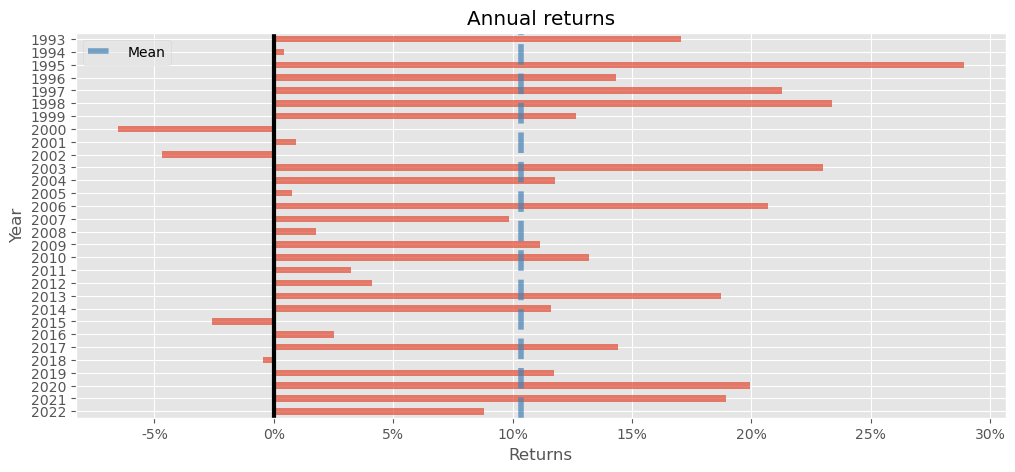

In [23]:
fig = plt.figure(figsize=(12,5))
pf.plot_annual_returns(Combined['50/50'])

<Axes: title={'center': 'Underwater plot'}, ylabel='Drawdown'>

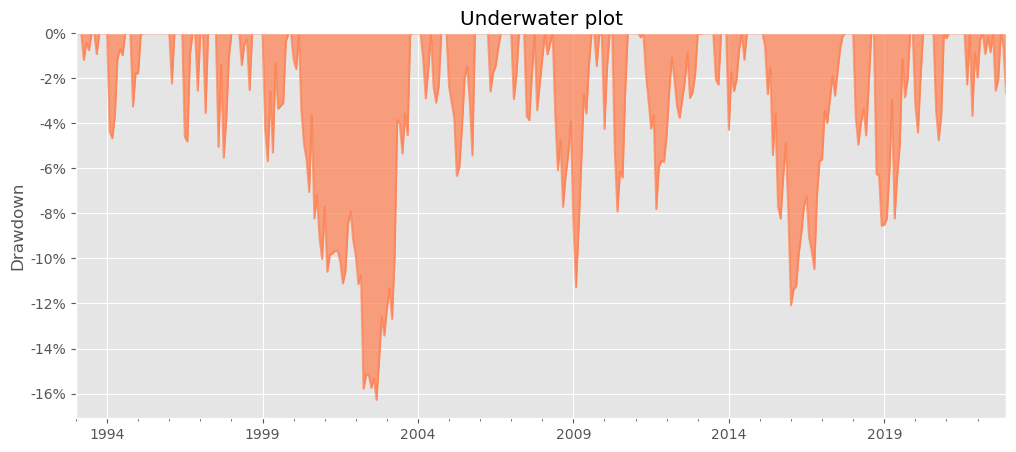

In [24]:
fig = plt.figure(figsize=(12,5))
pf.plot_drawdown_underwater(Combined['50/50'])

In [25]:
# Normalising strategy volatility to 20%
for i in Combined.columns:
    vol = Combined[i].std()*(12**0.5)
    scailer = 0.2/vol
    Combined[i] = Combined[i] * scailer

<function matplotlib.pyplot.show(close=None, block=None)>

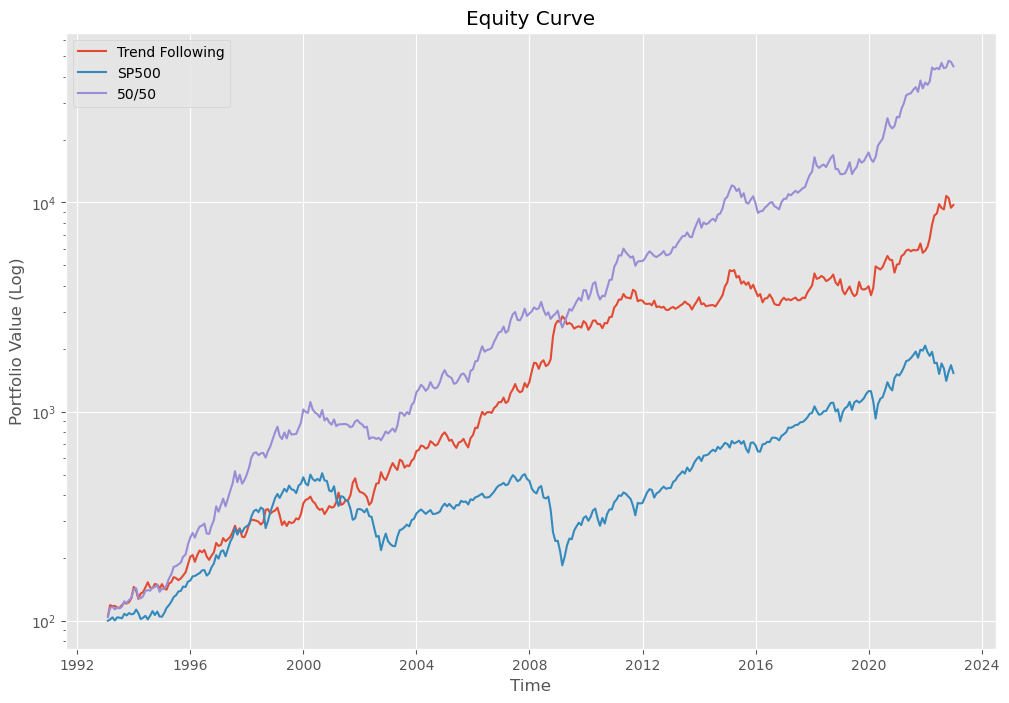

In [26]:
fig = plt.figure(figsize=(12,8))
plt.plot(Combined.index,(100*(Combined+1).cumprod()),label=Combined.columns)
plt.legend()
plt.yscale('log')
plt.ylabel('Portfolio Value (Log)')
plt.xlabel('Time')
plt.title('Equity Curve')
plt.show

# Insight

In [27]:
formation = dt.datetime(2006,1,31)
end_measurement = formation
slow_lookback = past_12.loc[end_measurement]
medium_looback = past_3.loc[end_measurement]
fast_lookback = past_1.loc[end_measurement]
merged = pd.concat([slow_lookback,medium_looback,fast_lookback],axis=1)
merged = merged[(merged != 0).all(axis=1)]
merged.dropna(inplace=True)
merged[merged > 0.0001] = 1
merged[merged < 0.0001] = -1
merged['position'] = merged.sum(axis=1)
vol_lookback = past_std.loc[end_measurement]
vol_lookback.dropna(inplace=True)
returns = monthly_returns.loc[end_measurement + MonthEnd(1),monthly_returns.columns.isin(merged.index)]
wppp = pd.concat([returns,merged['position'],vol_lookback],axis=1)
wppp = wppp[(wppp != 0).all(axis=1)]
wppp.dropna(inplace=True)
wppp['weighting'] = (1/wppp.iloc[:,2])/(sum(1/wppp.iloc[:,2])) * wppp.iloc[:,1]
months_profit = sum(wppp.iloc[:,0] * wppp.iloc[:,3])
momentum_profit = months_profit * (0.30/sum(wppp.iloc[:,3].abs() * (wppp.iloc[:,2])))
wppp['Pounds'] = ((wppp['weighting']/sum(wppp['weighting'])*1000000).abs()) * (0.30/sum(wppp.iloc[:,3].abs() * (wppp.iloc[:,2])))
wppp.columns = ['1 Month Forward Return','Signal','Ex Ante Vol Estimate','Weight','Notional Exposure £']
wppp['Notional Exposure £'] = wppp['Notional Exposure £'].apply(lambda x: '{:.2f}'.format(x))

In [28]:
wppp

,1 Month Forward Return,Signal,Ex Ante Vol Estimate,Weight,Notional Exposure £
CAC 40 Future,0.008364,3.0,0.119804,0.014614,28684.67
DAX Future,0.018871,3.0,0.127769,0.013703,26896.54
DJ EURO STOXX 50,0.019433,3.0,0.118416,0.014785,29020.83
Dow Jones,0.013076,3.0,0.097659,0.017928,35189.09
FTSE 100 Future,0.003831,3.0,0.092595,0.018908,37113.83
...,...,...,...,...,...
Soybean Futures,-0.023559,3.0,0.262356,0.006673,13098.79
British Pound,-0.014437,1.0,0.085958,0.006789,13326.38
Canadian Dollar,0.001137,3.0,0.076274,0.022954,45054.95
Euro,-0.020447,1.0,0.090235,0.006468,12694.85
